# Softmax Regression
:label:`sec_softmax`

In :numref:`sec_linear_regression`, we introduced linear regression,
working through implementations from scratch in :numref:`sec_linear_scratch`
and again using high-level APIs of a deep learning framework
in :numref:`sec_linear_concise` to do the heavy lifting.

Regression is the hammer we reach for when
we want to answer *how much?* or *how many?* questions.
If you want to predict the number of dollars (price)
at which a house will be sold,
or the number of wins a baseball team might have,
or the number of days that a patient
will remain hospitalized before being discharged,
then you are probably looking for a regression model.
However, even within regression models,
there are important distinctions.
For instance, the price of a house
will never be negative and changes might often be *relative* to its baseline price.
As such, it might be more effective to regress
on the logarithm of the price.
Likewise, the number of days a patient spends in hospital
is a *discrete nonnegative* random variable.
As such, least mean squares might not be an ideal approach either.
This sort of time-to-event modeling
comes with a host of other complications that are dealt with
in a specialized subfield called *survival modeling*.

The point here is not to overwhelm you but just
to let you know that there is a lot more to estimation
than simply minimizing squared errors.
And more broadly, there is a lot more to supervised learning than regression.
In this section, we focus on *classification* problems
where we put aside *how much?* questions
and instead focus on *which category?* questions.



* Does this email belong in the spam folder or the inbox?
* Is this customer more likely to sign up
  or not to sign up for a subscription service?
* Does this image depict a donkey, a dog, a cat, or a rooster?
* Which movie is Aston most likely to watch next?
* Which section of the book are you going to read next?

Colloquially, machine learning practitioners
overload the word *classification*
to describe two subtly different problems:
(i) those where we are interested only in
hard assignments of examples to categories (classes);
and (ii) those where we wish to make soft assignments,
i.e., to assess the probability that each category applies.
The distinction tends to get blurred, in part,
because often, even when we only care about hard assignments,
we still use models that make soft assignments.

Even more, there are cases where more than one label might be true.
For instance, a news article might simultaneously cover
the topics of entertainment, business, and space flight,
but not the topics of medicine or sports.
Thus, categorizing it into one of the above categories
on their own would not be very useful.
This problem is commonly known as [multi-label classification](https://en.wikipedia.org/wiki/Multi-label_classification).
See :citet:`Tsoumakas.Katakis.2007` for an overview
and :citet:`Huang.Xu.Yu.2015`
for an effective algorithm when tagging images.

## Classification
:label:`subsec_classification-problem`

To get our feet wet, let's start with
a simple image classification problem.
Here, each input consists of a $2\times2$ grayscale image.
We can represent each pixel value with a single scalar,
giving us four features $x_1, x_2, x_3, x_4$.
Further, let's assume that each image belongs to one
among the categories "cat", "chicken", and "dog".

Next, we have to choose how to represent the labels.
We have two obvious choices.
Perhaps the most natural impulse would be
to choose $y \in \{1, 2, 3\}$,
where the integers represent
$\{\textrm{dog}, \textrm{cat}, \textrm{chicken}\}$ respectively.
This is a great way of *storing* such information on a computer.
If the categories had some natural ordering among them,
say if we were trying to predict
$\{\textrm{baby}, \textrm{toddler}, \textrm{adolescent}, \textrm{young adult}, \textrm{adult}, \textrm{geriatric}\}$,
then it might even make sense to cast this as
an [ordinal regression](https://en.wikipedia.org/wiki/Ordinal_regression) problem
and keep the labels in this format.
See :citet:`Moon.Smola.Chang.ea.2010` for an overview
of different types of ranking loss functions
and :citet:`Beutel.Murray.Faloutsos.ea.2014` for a Bayesian approach
that addresses responses with more than one mode.

In general, classification problems do not come
with natural orderings among the classes.
Fortunately, statisticians long ago invented a simple way
to represent categorical data: the *one-hot encoding*.
A one-hot encoding is a vector
with as many components as we have categories.
The component corresponding to a particular instance's category is set to 1
and all other components are set to 0.
In our case, a label $y$ would be a three-dimensional vector,
with $(1, 0, 0)$ corresponding to "cat", $(0, 1, 0)$ to "chicken",
and $(0, 0, 1)$ to "dog":

$$y \in \{(1, 0, 0), (0, 1, 0), (0, 0, 1)\}.$$

### Linear Model

In order to estimate the conditional probabilities
associated with all the possible classes,
we need a model with multiple outputs, one per class.
To address classification with linear models,
we will need as many affine functions as we have outputs.
Strictly speaking, we only need one fewer,
since the final category has to be the difference
between $1$ and the sum of the other categories,
but for reasons of symmetry
we use a slightly redundant parametrization.
Each output corresponds to its own affine function.
In our case, since we have 4 features and 3 possible output categories,
we need 12 scalars to represent the weights ($w$ with subscripts),
and 3 scalars to represent the biases ($b$ with subscripts). This yields:

$$
\begin{aligned}
o_1 &= x_1 w_{11} + x_2 w_{12} + x_3 w_{13} + x_4 w_{14} + b_1,\\
o_2 &= x_1 w_{21} + x_2 w_{22} + x_3 w_{23} + x_4 w_{24} + b_2,\\
o_3 &= x_1 w_{31} + x_2 w_{32} + x_3 w_{33} + x_4 w_{34} + b_3.
\end{aligned}
$$

The corresponding neural network diagram
is shown in :numref:`fig_softmaxreg`.
Just as in linear regression,
we use a single-layer neural network.
And since the calculation of each output, $o_1, o_2$, and $o_3$,
depends on every input, $x_1$, $x_2$, $x_3$, and $x_4$,
the output layer can also be described as a *fully connected layer*.

![Softmax regression is a single-layer neural network.](http://d2l.ai/_images/softmaxreg.svg)
:label:`fig_softmaxreg`

For a more concise notation we use vectors and matrices:
$\mathbf{o} = \mathbf{W} \mathbf{x} + \mathbf{b}$ is
much better suited for mathematics and code.
Note that we have gathered all of our weights into a $3 \times 4$ matrix and all biases
$\mathbf{b} \in \mathbb{R}^3$ in a vector.

### The Softmax
:label:`subsec_softmax_operation`

Assuming a suitable loss function,
we could try, directly, to minimize the difference
between $\mathbf{o}$ and the labels $\mathbf{y}$.
While it turns out that treating classification
as a vector-valued regression problem works surprisingly well,
it is nonetheless unsatisfactory in the following ways:

* There is no guarantee that the outputs $o_i$ sum up to $1$ in the way we expect probabilities to behave.
* There is no guarantee that the outputs $o_i$ are even nonnegative, even if their outputs sum up to $1$, or that they do not exceed $1$.

Both aspects render the estimation problem difficult to solve
and the solution very brittle to outliers.
For instance, if we assume that there
is a positive linear dependency
between the number of bedrooms and the likelihood
that someone will buy a house,
the probability might exceed $1$
when it comes to buying a mansion!
As such, we need a mechanism to "squish" the outputs.

There are many ways we might accomplish this goal.
For instance, we could assume that the outputs
$\mathbf{o}$ are corrupted versions of $\mathbf{y}$,
where the corruption occurs by means of adding noise $\boldsymbol{\epsilon}$
drawn from a normal distribution.
In other words, $\mathbf{y} = \mathbf{o} + \boldsymbol{\epsilon}$,
where $\epsilon_i \sim \mathcal{N}(0, \sigma^2)$.
This is the so-called [probit model](https://en.wikipedia.org/wiki/Probit_model),
first introduced by :citet:`Fechner.1860`.
While appealing, it does not work quite as well
nor lead to a particularly nice optimization problem,
when compared to the softmax.

Another way to accomplish this goal
(and to ensure nonnegativity) is to use
an exponential function $P(y = i) \propto \exp o_i$.
This does indeed satisfy the requirement
that the conditional class probability
increases with increasing $o_i$, it is monotonic,
and all probabilities are nonnegative.
We can then transform these values so that they add up to $1$
by dividing each by their sum.
This process is called *normalization*.
Putting these two pieces together
gives us the *softmax* function:

$$\hat{\mathbf{y}} = \mathrm{softmax}(\mathbf{o}) \quad \textrm{where}\quad \hat{y}_i = \frac{\exp(o_i)}{\sum_j \exp(o_j)}.$$
:eqlabel:`eq_softmax_y_and_o`

Note that the largest coordinate of $\mathbf{o}$
corresponds to the most likely class according to $\hat{\mathbf{y}}$.
Moreover, because the softmax operation
preserves the ordering among its arguments,
we do not need to compute the softmax
to determine which class has been assigned the highest probability. Thus,

$$
\operatorname*{argmax}_j \hat y_j = \operatorname*{argmax}_j o_j.
$$


The idea of a softmax dates back to :citet:`Gibbs.1902`,
who adapted ideas from physics.
Dating even further back, Boltzmann,
the father of modern statistical physics,
used this trick to model a distribution
over energy states in gas molecules.
In particular, he discovered that the prevalence
of a state of energy in a thermodynamic ensemble,
such as the molecules in a gas,
is proportional to $\exp(-E/kT)$.
Here, $E$ is the energy of a state,
$T$ is the temperature, and $k$ is the Boltzmann constant.
When statisticians talk about increasing or decreasing
the "temperature" of a statistical system,
they refer to changing $T$
in order to favor lower or higher energy states.
Following Gibbs' idea, energy equates to error.
Energy-based models :cite:`Ranzato.Boureau.Chopra.ea.2007`
use this point of view when describing
problems in deep learning.

### Vectorization
:label:`subsec_softmax_vectorization`

To improve computational efficiency,
we vectorize calculations in minibatches of data.
Assume that we are given a minibatch $\mathbf{X} \in \mathbb{R}^{n \times d}$
of $n$ examples with dimensionality (number of inputs) $d$.
Moreover, assume that we have $q$ categories in the output.
Then the weights satisfy $\mathbf{W} \in \mathbb{R}^{d \times q}$
and the bias satisfies $\mathbf{b} \in \mathbb{R}^{1\times q}$.

$$ \begin{aligned} \mathbf{O} &= \mathbf{X} \mathbf{W} + \mathbf{b}, \\ \hat{\mathbf{Y}} & = \mathrm{softmax}(\mathbf{O}). \end{aligned} $$
:eqlabel:`eq_minibatch_softmax_reg`

This accelerates the dominant operation into
a matrix--matrix product $\mathbf{X} \mathbf{W}$.
Moreover, since each row in $\mathbf{X}$ represents a data example,
the softmax operation itself can be computed *rowwise*:
for each row of $\mathbf{O}$, exponentiate all entries
and then normalize them by the sum.
Note, though, that care must be taken
to avoid exponentiating and taking logarithms of large numbers,
since this can cause numerical overflow or underflow.
Deep learning frameworks take care of this automatically.

## Loss Function
:label:`subsec_softmax-regression-loss-func`

Now that we have a mapping from features $\mathbf{x}$
to probabilities $\mathbf{\hat{y}}$,
we need a way to optimize the accuracy of this mapping.
We will rely on maximum likelihood estimation,
the very same method that we encountered
when providing a probabilistic justification
for the mean squared error loss in
:numref:`subsec_normal_distribution_and_squared_loss`.

### Log-Likelihood

The softmax function gives us a vector $\hat{\mathbf{y}}$,
which we can interpret as the (estimated) conditional probabilities
of each class, given any input $\mathbf{x}$,
such as $\hat{y}_1$ = $P(y=\textrm{cat} \mid \mathbf{x})$.
In the following we assume that for a dataset
with features $\mathbf{X}$ the labels $\mathbf{Y}$
are represented using a one-hot encoding label vector.
We can compare the estimates with reality
by checking how probable the actual classes are
according to our model, given the features:

$$
P(\mathbf{Y} \mid \mathbf{X}) = \prod_{i=1}^n P(\mathbf{y}^{(i)} \mid \mathbf{x}^{(i)}).
$$

We are allowed to use the factorization
since we assume that each label is drawn independently
from its respective distribution $P(\mathbf{y}\mid\mathbf{x}^{(i)})$.
Since maximizing the product of terms is awkward,
we take the negative logarithm to obtain the equivalent problem
of minimizing the negative log-likelihood:

$$
-\log P(\mathbf{Y} \mid \mathbf{X}) = \sum_{i=1}^n -\log P(\mathbf{y}^{(i)} \mid \mathbf{x}^{(i)})
= \sum_{i=1}^n l(\mathbf{y}^{(i)}, \hat{\mathbf{y}}^{(i)}),
$$

where for any pair of label $\mathbf{y}$
and model prediction $\hat{\mathbf{y}}$
over $q$ classes, the loss function $l$ is

$$ l(\mathbf{y}, \hat{\mathbf{y}}) = - \sum_{j=1}^q y_j \log \hat{y}_j. $$
:eqlabel:`eq_l_cross_entropy`

For reasons explained later on,
the loss function in :eqref:`eq_l_cross_entropy`
is commonly called the *cross-entropy loss*.
Since $\mathbf{y}$ is a one-hot vector of length $q$,
the sum over all its coordinates $j$ vanishes for all but one term.
Note that the loss $l(\mathbf{y}, \hat{\mathbf{y}})$
is bounded from below by $0$
whenever $\hat{\mathbf{y}}$ is a probability vector:
no single entry is larger than $1$,
hence their negative logarithm cannot be lower than $0$;
$l(\mathbf{y}, \hat{\mathbf{y}}) = 0$ only if we predict
the actual label with *certainty*.
This can never happen for any finite setting of the weights
because taking a softmax output towards $1$
requires taking the corresponding input $o_i$ to infinity
(or all other outputs $o_j$ for $j \neq i$ to negative infinity).
Even if our model could assign an output probability of $0$,
any error made when assigning such high confidence
would incur infinite loss ($-\log 0 = \infty$).


### Softmax and Cross-Entropy Loss
:label:`subsec_softmax_and_derivatives`

Since the softmax function
and the corresponding cross-entropy loss are so common,
it is worth understanding a bit better how they are computed.
Plugging :eqref:`eq_softmax_y_and_o` into the definition of the loss
in :eqref:`eq_l_cross_entropy`
and using the definition of the softmax we obtain

$$
\begin{aligned}
l(\mathbf{y}, \hat{\mathbf{y}}) &=  - \sum_{j=1}^q y_j \log \frac{\exp(o_j)}{\sum_{k=1}^q \exp(o_k)} \\
&= \sum_{j=1}^q y_j \log \sum_{k=1}^q \exp(o_k) - \sum_{j=1}^q y_j o_j \\
&= \log \sum_{k=1}^q \exp(o_k) - \sum_{j=1}^q y_j o_j.
\end{aligned}
$$

To understand a bit better what is going on,
consider the derivative with respect to any logit $o_j$. We get

$$
\partial_{o_j} l(\mathbf{y}, \hat{\mathbf{y}}) = \frac{\exp(o_j)}{\sum_{k=1}^q \exp(o_k)} - y_j = \mathrm{softmax}(\mathbf{o})_j - y_j.
$$

In other words, the derivative is the difference
between the probability assigned by our model,
as expressed by the softmax operation,
and what actually happened, as expressed
by elements in the one-hot label vector.
In this sense, it is very similar
to what we saw in regression,
where the gradient was the difference
between the observation $y$ and estimate $\hat{y}$.
This is not a coincidence.
In any exponential family model,
the gradients of the log-likelihood are given by precisely this term.
This fact makes computing gradients easy in practice.

Now consider the case where we observe not just a single outcome
but an entire distribution over outcomes.
We can use the same representation as before for the label $\mathbf{y}$.
The only difference is that rather
than a vector containing only binary entries,
say $(0, 0, 1)$, we now have a generic probability vector,
say $(0.1, 0.2, 0.7)$.
The math that we used previously to define the loss $l$
in :eqref:`eq_l_cross_entropy`
still works well,
just that the interpretation is slightly more general.
It is the expected value of the loss for a distribution over labels.
This loss is called the *cross-entropy loss* and it is
one of the most commonly used losses for classification problems.
We can demystify the name by introducing just the basics of information theory.
In a nutshell, it measures the number of bits needed to encode what we see, $\mathbf{y}$,
relative to what we predict that should happen, $\hat{\mathbf{y}}$.
We provide a very basic explanation in the following. For further
details on information theory see
:citet:`Cover.Thomas.1999` or :citet:`mackay2003information`.



## Information Theory Basics
:label:`subsec_info_theory_basics`

Many deep learning papers use intuition and terms from information theory.
To make sense of them, we need some common language.
This is a survival guide.
*Information theory* deals with the problem
of encoding, decoding, transmitting,
and manipulating information (also known as data).

### Entropy

The central idea in information theory is to quantify the
amount of information contained in data.
This places a  limit on our ability to compress data.
For a distribution $P$ its *entropy*, $H[P]$, is defined as:

$$H[P] = \sum_j - P(j) \log P(j).$$
:eqlabel:`eq_softmax_reg_entropy`

One of the fundamental theorems of information theory states
that in order to encode data drawn randomly from the distribution $P$,
we need at least $H[P]$ "nats" to encode it :cite:`Shannon.1948`.
If you wonder what a "nat" is, it is the equivalent of bit
but when using a code with base $e$ rather than one with base 2.
Thus, one nat is $\frac{1}{\log(2)} \approx 1.44$ bit.


### Surprisal

You might be wondering what compression has to do with prediction.
Imagine that we have a stream of data that we want to compress.
If it is always easy for us to predict the next token,
then this data is easy to compress.
Take the extreme example where every token in the stream
always takes the same value.
That is a very boring data stream!
And not only it is boring, but it is also easy to predict.
Because the tokens are always the same,
we do not have to transmit any information
to communicate the contents of the stream.
Easy to predict, easy to compress.

However if we cannot perfectly predict every event,
then we might sometimes be surprised.
Our surprise is greater when an event is assigned lower probability.
Claude Shannon settled on $\log \frac{1}{P(j)} = -\log P(j)$
to quantify one's *surprisal* at observing an event $j$
having assigned it a (subjective) probability $P(j)$.
The entropy defined in :eqref:`eq_softmax_reg_entropy`
is then the *expected surprisal*
when one assigned the correct probabilities
that truly match the data-generating process.


### Cross-Entropy Revisited

So if entropy is the level of surprise experienced
by someone who knows the true probability,
then you might be wondering, what is cross-entropy?
The cross-entropy *from* $P$ *to* $Q$, denoted $H(P, Q)$,
is the expected surprisal of an observer with subjective probabilities $Q$
upon seeing data that was actually generated according to probabilities $P$.
This is given by $H(P, Q) \stackrel{\textrm{def}}{=} \sum_j - P(j) \log Q(j)$.
The lowest possible cross-entropy is achieved when $P=Q$.
In this case, the cross-entropy from $P$ to $Q$ is $H(P, P)= H(P)$.

In short, we can think of the cross-entropy classification objective
in two ways: (i) as maximizing the likelihood of the observed data;
and (ii) as minimizing our surprisal (and thus the number of bits)
required to communicate the labels.

## Summary and Discussion

In this section, we encountered the first nontrivial loss function,
allowing us to optimize over *discrete* output spaces.
Key in its design was that we took a probabilistic approach,
treating discrete categories as instances of draws from a probability distribution.
As a side effect, we encountered the softmax,
a convenient activation function that transforms
outputs of an ordinary neural network layer
into valid discrete probability distributions.
We saw that the derivative of the cross-entropy loss
when combined with softmax
behaves very similarly
to the derivative of squared error;
namely by taking the difference between
the expected behavior and its prediction.
And, while we were only able to
scratch the very surface of it,
we encountered exciting connections
to statistical physics and information theory.

While this is enough to get you on your way,
and hopefully enough to whet your appetite,
we hardly dived deep here.
Among other things, we skipped over computational considerations.
Specifically, for any fully connected layer with $d$ inputs and $q$ outputs,
the parametrization and computational cost is $\mathcal{O}(dq)$,
which can be prohibitively high in practice.
Fortunately, this cost of transforming $d$ inputs into $q$ outputs
can be reduced through approximation and compression.
For instance Deep Fried Convnets :cite:`Yang.Moczulski.Denil.ea.2015`
uses a combination of permutations,
Fourier transforms, and scaling
to reduce the cost from quadratic to log-linear.
Similar techniques work for more advanced
structural matrix approximations :cite:`sindhwani2015structured`.
Lastly, we can use quaternion-like decompositions
to reduce the cost to $\mathcal{O}(\frac{dq}{n})$,
again if we are willing to trade off a small amount of accuracy
for computational and storage cost :cite:`Zhang.Tay.Zhang.ea.2021`
based on a compression factor $n$.
This is an active area of research.
What makes it challenging is that
we do not necessarily strive
for the most compact representation
or the smallest number of floating point operations
but rather for the solution
that can be executed most efficiently on modern GPUs.

## Exercises

1. We can explore the connection between exponential families and softmax in some more depth.
    1. Compute the second derivative of the cross-entropy loss $l(\mathbf{y},\hat{\mathbf{y}})$ for softmax.
    1. Compute the variance of the distribution given by $\mathrm{softmax}(\mathbf{o})$ and show that it matches the second derivative computed above.
1. Assume that we have three classes which occur with equal probability, i.e., the probability vector is $(\frac{1}{3}, \frac{1}{3}, \frac{1}{3})$.
    1. What is the problem if we try to design a binary code for it?
    1. Can you design a better code? Hint: what happens if we try to encode two independent observations? What if we encode $n$ observations jointly?
1. When encoding signals transmitted over a physical wire, engineers do not always use binary codes. For instance, [PAM-3](https://en.wikipedia.org/wiki/Ternary_signal) uses three signal levels $\{-1, 0, 1\}$ as opposed to two levels $\{0, 1\}$. How many ternary units do you need to transmit an integer in the range $\{0, \ldots, 7\}$? Why might this be a better idea in terms of electronics?
1. The [Bradley--Terry model](https://en.wikipedia.org/wiki/Bradley%E2%80%93Terry_model) uses
a logistic model to capture preferences. For a user to choose between apples and oranges one
assumes scores $o_{\textrm{apple}}$ and $o_{\textrm{orange}}$. Our requirements are that larger scores should lead to a higher likelihood in choosing the associated item and that
the item with the largest score is the most likely one to be chosen :cite:`Bradley.Terry.1952`.
    1. Prove that softmax satisfies this requirement.
    1. What happens if you want to allow for a default option of choosing neither apples nor oranges? Hint: now the user has three choices.
1. Softmax gets its name from the following mapping: $\textrm{RealSoftMax}(a, b) = \log (\exp(a) + \exp(b))$.
    1. Prove that $\textrm{RealSoftMax}(a, b) > \mathrm{max}(a, b)$.
    1. How small can you make the difference between both functions? Hint: without loss of
    generality you can set $b = 0$ and $a \geq b$.
    1. Prove that this holds for $\lambda^{-1} \textrm{RealSoftMax}(\lambda a, \lambda b)$, provided that $\lambda > 0$.
    1. Show that for $\lambda \to \infty$ we have $\lambda^{-1} \textrm{RealSoftMax}(\lambda a, \lambda b) \to \mathrm{max}(a, b)$.
    1. Construct an analogous softmin function.
    1. Extend this to more than two numbers.
1. The function $g(\mathbf{x}) \stackrel{\textrm{def}}{=} \log \sum_i \exp x_i$ is sometimes also referred to as the [log-partition function](https://en.wikipedia.org/wiki/Partition_function_(mathematics)).
    1. Prove that the function is convex. Hint: to do so, use the fact that the first derivative amounts to the probabilities from the softmax function and show that the second derivative is the variance.
    1. Show that $g$ is translation invariant, i.e., $g(\mathbf{x} + b) = g(\mathbf{x})$.
    1. What happens if some of the coordinates $x_i$ are very large? What happens if they're all very small?
    1. Show that if we choose $b = \mathrm{max}_i x_i$ we end up with a numerically stable implementation.
1. Assume that we have some probability distribution $P$. Suppose we pick another distribution $Q$ with $Q(i) \propto P(i)^\alpha$ for $\alpha > 0$.
    1. Which choice of $\alpha$ corresponds to doubling the temperature? Which choice corresponds to halving it?
    1. What happens if we let the temperature approach $0$?
    1. What happens if we let the temperature approach $\infty$?

[Discussions](https://discuss.d2l.ai/t/46)


In [ ]:
#notes
'''
this is why we need to softmax:
the model gives linear outputs, but the math assumes they are logs of probabilities to make optimization easier,
which is just the negative log loss/ cross entropy. (sum of -logloss instead of product of loss)
this results in weights being logarithmic, where a logit of 10 is not 5x more likely than a logit of 2.
then we exponentiate to get actual probabilities, so, we "unlog" them when we want to see the true distribution.

H[P]=sum of -P(x_i)*logP(x_i)
x_i is how common the event is, where x_i is drawn from distribution P. what this means is that less likely events
are more costly to encode, as x_i is a probability from 0 to 1, so the lower it is logP() increases.

In [ ]:
#1
'''
1.
e^o_j/sigma(e^o_k) - yj

let S = sigma(e^o_k)

(e^o_j * S - e^o_j * e^o_j)/S^2

= e^o_j / S - (e^o_j * e^o_j)/S^2
= softmax(o_j) - softmax(o_j)^2
=softmax(o_j) * (1 - softmax(o_j))


2.
a variable that equals 1 when class j is chosen, and 0 otherwise is called a bernoulli random variable.
the formula for its variance is p_j(1 - p_j). this is just the same as part 1
'''

#2
'''
1.
[1/3, 1/3, 1/3]
the problem with giving it a binary code is that it has 3 categories. i assume that we must have an equal data type for this.
as such, our minimal prefix free bit count would be 00, 01, and 10 to encode these three categories. this uses two bits to send one class.
but as per the compression info thing, log_2_3 is roughly 1.58 bits. so we are not being as efficient as possible

2.

we can change this just by making one category shorter while still being prefix free.
we can thus use:
1 00 01
as our three codes, which has an average bit length of 1.667 bits.
we cannot shorten it further. if we used 0 and 1 as two bits, then whatever the 2 digit 3rd binary code will result in it no
longer being prefix free.


if you encode 2 examples at once, you can achieve closer to maximum effieciency

amount encoded per bit them becomes 2 * 1.58 = 3.16 per 2 bits
Pair	Binary Code
(1,1)	000  (1,2)	001  (1,3)	010  (2,1)	011  (2,2)	100  (2,3)	101  (3,1)	110  (3,2)	1110  (3,3)	1111

this has an average bit length of 3.22 per 2 bits, or 1.61 per bit.
'''

#3
'''
3*3 = 9
one bit only has 3 options, so not enough to transmit 8 different integers
so you need 2 bits to transmit integers from 0 to 7
i assume this is better for electronics simply because you just have the channel there. you can have positive current, no current,
and negative current, so you are just making efficient use of the medium
'''

#4
'''
1.
this thing is literally just an example of softmax with a 2 element one hot vector

onehot = [apple, orange]

lets assume we are trying to see if apple gets a higher score than orange.
softmax: exp(o_j)/sigma(exp(o_k))
this is just: exp(apple)/(exp(apple) + exp(orange)), which is literally the same as the bradly terry p_i/(p_i+p_j) but adjust for log weights.
both are finding the probability of a single class over the sum of the probabilites of all classes, where the values for each
class afterwards are monotonically consistent with the original probabilities or rankings.

2.
i assume it just is asking for what the bradley terry model would look like with 3 categories. this
this would just be apple / apple + orange + neither
'''

#5
'''
1.
assume a is the larger of a,b:
realsoftmax = log(exp(a) + exp(b))
realsoftmax = log(exp(a)) + log (1+exp(b)/exp(a))
realsoftmax = a + log(1+exp(b)/exp(a))

so, given exp(b) and exp(b) must be positive, so must exp(b)/exp(a).
1+exp(b)/exp(a) > 1

and given the log of any number great than 1 is positive,
realsoftmax = a + positive > a
so, realsoftmax(a, b), is always larger than max(a, b)
i guess this means that softmaxing always creates a spikier distribution.

2.
the difference is log (1+exp(b)/exp(a)).
as per the instructions, wlog, b = 0,  exp(b) = 1 let a remain a variable
then realsoftmax = a + log(1 + 1/exp(a))

 log(1 + 1/exp(a)) -> 0   as  exp(a) -> infinity

so, realsoftmax - max -> 0  as a -> infinity

this obviously holds for all cases as as a -> infinity and b remains constant, exp(b)/exp(a) -> 0


3.
let a > b
(1/lambda)*realsoftmax(lambda * a, lambda * b) > max(lambda * a, lambda * b)

realsoftmax = log(exp(lambda * a) + exp(lambda * b))
realsoftmax = log(exp(lambda * a)) + log (1+exp(lambda * b)/exp(lambda * a))
realsoftmax = (1/lambda) * (lambda * a + log(1+exp(lambda * b)/exp(lambda * a))
realsoftmax = a + (1/lambda) * log(1+exp(lambda * b)/exp(lambda * a))

same as part 1, log(1+exp(lambda * b)/exp(lambda * a)) must be positive.
1/lambda is also always positive. so, 1/lambda * log(1+exp(lambda * b)/exp(lambda * a)) must also be positive.
once again, we have a + positive > a

4.
we found in part 3: realsoftmax = a + (1/lambda) * log(1+exp(lambda * b)/exp(lambda * a))

as lambda -> infinity, 1/lambda -> 0, so (1/lambda) * log(1+exp(lambda * b)/exp(lambda * a)) -> 0
then we are left with realsoftmax = a = max(a, b)

5.
i assume by softmin it is the inverse of softmax, where the smallest gets the highest probability.

this just inverts the thing. so then we have realsoftmin = log(exp(-a) + exp(-b)) < min(a, b)

6.
by extend to more i assume it means realsoftmax

realsoftmax = log(exp(a) + exp(b) + exp(c))
realsoftmax = a + log(exp(b)/exp(a)) + log ((exp(b) + exp(c))/log(a))^2 +

-1^n * log ((exp(n) + exp(n-1) + ... exp(n_2)/n_1) for all terms up to n
'''

#6
'''
1.
this is literally RealSoftMax

derivative of log(sigma(exp(x_i))) = exp(x_i)/sigma(x_j) with respect to any x_i

this is the same as the first part of the 1st derivative of softmax, the part that represents the probability of x_i

let S = sigma(e^x_j)

(e^x_i * S - e^x_i * e^x_i)/S^2

= e^o_j / S - (e^x_i * e^x_i)/S^2
= softmax(x_i) - softmax(x_i)^2
=softmax(x_i) * (1 - softmax(x_i))

for a bernoulli random variable, the formula for its variance is p_j(1 - p_j). this means the second derivative is the same as the variance.
p_j(1 - p_j) = p_j - p_j ^ 2
the variance is a quadratic and concave. so the requirements for the function to be convex is:
the rightmost root is greater than or equal to zero, and the second derivative is greater than zero for all x > 0,
and the second derivative is decreasing as x increases. as p_j can only take values between 0 and 1 inclusive,
and the rightmost root of the function is 1, all the conditions are met, so this function g(x) is indeed convex

2.
log(sigma(exp(x_i+b))
= log(sigma(exp(x_i)*exp(b))
= log(exp(b)*sigma(exp(x_i))
= b + log(sigma(exp(x_i))
= b + g(x)
so it doesn't matter where the constant is placed, and as such is translation invariant.

3.
logsumexp functions as a smooth interpolation between the pointwise maximum of the elements of x. so it will never be
larger faster than the sum of of the elements of x. it will however exceed the maximum value of x_i, as proved earlier.
so when there are a few large values, it grows a bit faster than the highest value. this makes logsumexp diverge from
the mean value at that point.
when there are all very small (well i guess the bigger point is that they are similar), it still grows a bit faster than
the highest value, but is much closer to the mean value.

cross entropy loss for both remains high, as it is relative. logsumexp is closests to sigma(y_j * o_j), as this is just
the correct onehot, when everything is low and one logit probability is very high, because every other logits probability
also increases logsumexp, which we don't want.

random cross entropy loss stuff:
log(sigma(exp(o_k))) - sigma(y_j * o_j)
what this means is that having a large value of o_j results in a lower cross entropy loss, while having many small
values has a higher cross entropy loss, as sigma(y_j * o_j) should be zero apart one that is on.
'''


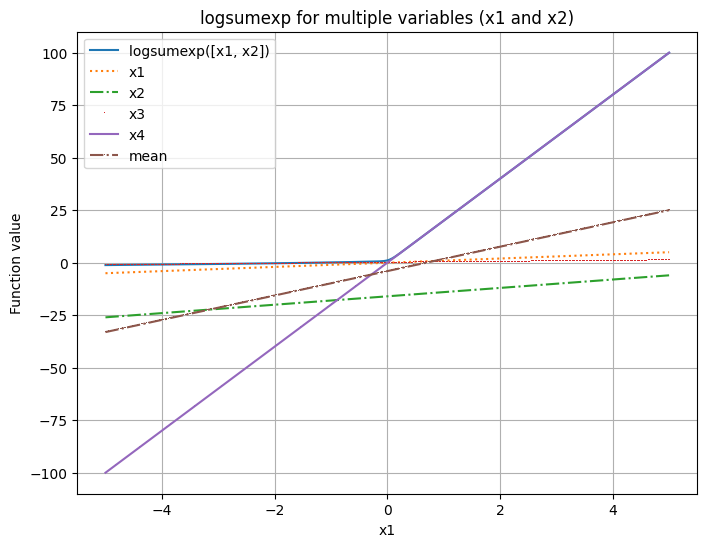

In [19]:
#FOR QUESTION 6 TESTING
import matplotlib.pyplot as plt

import numpy as np
from scipy.special import logsumexp
# Define multiple input vectors
x1 = np.linspace(-5, 5, 400)
x2 = 2 * (x1-8)  # A second variable dependent on x1
x3 = 0.23* (x1)
x4 = 20 * x1

mean = (x1 + x2 + x3 + x4)/4
# Stack inputs for logsumexp over axis=0 (treat each column as a sample)
X = np.vstack([x1, x2, x3, x4])
lse_multi = logsumexp(X, axis=0)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(x1, lse_multi, label='logsumexp([x1, x2])')
plt.plot(x1, x1, ':', label='x1')
plt.plot(x1, x2, '-.', label='x2')
plt.plot(x1, x3, ',', label='x3')
plt.plot(x1, x4, '-,', label='x4')
plt.plot(x1, mean, '-.,', label='mean')

plt.title('logsumexp for multiple variables (x1 and x2)')
plt.xlabel('x1')
plt.ylabel('Function value')
plt.legend()
plt.grid(True)
plt.show()
